# Making a figure looking at $b^2$

This notebook is used to make a figure for the halo bais paper. It will use some modules that aren't dependencies of this one, so it likely won't run for a user.

In [1]:
import numpy as np
import bias_emulator
import hmf_emulator
import aemulus_data as AD
import aemulus_extras as ae
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
%matplotlib inline

In [2]:
plt.rc("font", size=16, family="serif")
plt.rc("errorbar", capsize=3)
plt.rc("text", usetex=True)

In [3]:
cosmo_index = 0
#Note: we remove sigma8 from the list of parameters
cosmology = AD.building_box_cosmologies()[cosmo_index][:-1]
cosmo_dict = {"omega_b":cosmology[0], "omega_cdm":cosmology[1], "w0":cosmology[2],
             "n_s":cosmology[3], "ln10As":cosmology[4],"H0":cosmology[5],"N_eff":cosmology[6]}
print("Cosmology for building simulation %d loaded"%cosmo_index)
Extras = ae.Extras(cosmo_index, testing=False) #Testing cosmos == MedBox cosmos

Cosmology for building simulation 0 loaded


In [4]:
#Create emulators
bias_emu = bias_emulator.bias_emulator()
bias_emu.set_cosmology(cosmo_dict)
hmf_emu = hmf_emulator.hmf_emulator()
hmf_emu.set_cosmology(cosmo_dict)

In [5]:
#Make a function to get halo data
def get_halo_data(snap, auto=False):
    datapath = "./data_for_plots/"
    _, Mlos, Mhis, Masses = np.loadtxt(datapath+"Box000_Z%d_halo_means_hmcf.txt"%snap, 
                                       unpack=True)
    Mhis[-1] = 10**16.5
    return Mlos, Mhis, Masses

redshifts = 1./AD.scale_factors() - 1
colors = [plt.get_cmap("seismic")(ci) for ci in np.linspace(1.0, 0.0, len(redshifts))]

In [6]:
def get_bias_data(snap, auto=False):
    datapath = "./data_for_plots/"
    inpath = datapath+"Box000_Z%d_DS50_linearbias.txt"%snap
    if auto:
        inpath = datapath+"Box000_Z%d_DS50_auto_linearbias.txt"%snap
    _, _, _, b, be = np.loadtxt(inpath, unpack=True)
    if auto:
        b = np.sqrt(b)
        be = be/(2*b)
    return b, be

In [7]:
#Write a function to get the correct bin-averaged bias
def bin_ave_biases_in_snap(snap):
    
    Mlos, Mhis, Masses = get_halo_data(snap)
    
    Marr = np.logspace(np.log10(Mlos[0]), np.log10(Mhis[-1]), 1000)
    lnMarr = np.log(Marr)
    bias_at_Marr = bias_emu.bias(Marr, redshifts[snap])
    dndM_at_Marr = hmf_emu.dndM(Marr, redshifts[snap])
    
    bhmf_spl = IUS(lnMarr, bias_at_Marr*dndM_at_Marr*Marr)
    hmf_spl = IUS(lnMarr, dndM_at_Marr*Marr)

    lnMlos = np.log(Mlos)
    lnMhis = np.log(Mhis)
    
    output = np.zeros_like(Mlos)
    for i in range(len(output)):
        num = bhmf_spl.integral(lnMlos[i], lnMhis[i])
        den = hmf_spl.integral(lnMlos[i], lnMhis[i])
        output[i] = num/den
    return output

In [8]:
#Write a function to get the correct bin-averaged bias^2
def bin_ave_b2_in_snap(snap):
    
    Mlos, Mhis, Masses = get_halo_data(snap)
    
    Marr = np.logspace(np.log10(Mlos[0]), np.log10(Mhis[-1]), 1000)
    lnMarr = np.log(Marr)
    bias_at_Marr = bias_emu.bias(Marr, redshifts[snap])
    dndM_at_Marr = hmf_emu.dndM(Marr, redshifts[snap])
    
    b2hmf_spl = IUS(lnMarr, bias_at_Marr*bias_at_Marr*dndM_at_Marr*Marr)
    hmf_spl = IUS(lnMarr, dndM_at_Marr*Marr)

    lnMlos = np.log(Mlos)
    lnMhis = np.log(Mhis)
    
    output = np.zeros_like(Mlos)
    for i in range(len(output)):
        num = b2hmf_spl.integral(lnMlos[i], lnMhis[i])
        den = hmf_spl.integral(lnMlos[i], lnMhis[i])
        output[i] = num/den
    return output

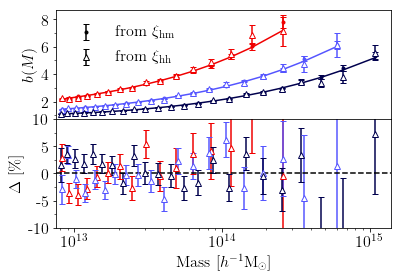

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)#, figsize=(9,4))
plt.subplots_adjust(hspace=0.0)
ax[0].set_xscale('log')
ax[0].set_ylabel(r"$b(M)$")
ax[1].set_ylabel(r"$\Delta\ [\%]$")
ax[1].set_xlabel(r"${\rm Mass}\ [h^{-1}{\rm M_\odot}]$")
ax[1].set_ylim(-10, 10)
ax[0].set_yticks([2,4,6,8])
ax[0].set_yticklabels([2,4,6,8])
ax[0].set_yticks([1,3,5,7], minor=True)
ax[1].set_yticks([-10, -5, 0, 5, 10])
ax[1].set_yticklabels([-10, -5, 0, 5, 10])
ax[1].set_yticks([-7.5, -2.5, 2.5, 7.5], minor=True)

snaps = [2,6,9]
MS = 6 #markersize
for snap in snaps:
    _, _, M = get_halo_data(snap)
    
    bm = bin_ave_biases_in_snap(snap)
    ax[0].plot(M, bm, c=colors[snap], zorder=-1)
    
    b_data1, be_data1 = get_bias_data(snap, auto=False)
    ax[0].errorbar(M, b_data1, be_data1, c=colors[snap], ls='', marker='.', markersize=MS)
    #ax[1].errorbar(M, (b_data1-bm)/bm*100, be_data1/bm*100, c=colors[snap], ls='', marker='.', markersize=MS)
    
    b_data2, be_data2 = get_bias_data(snap, auto=True)
    ax[0].errorbar(M, b_data2, be_data2, c=colors[snap], ls='', marker='^', mfc='w', markersize=MS)
    ax[1].errorbar(M, (b_data2-bm)/bm*100, be_data2/bm*100, c=colors[snap], ls='', marker='^', mfc="w", markersize=MS)
    #err = np.sqrt((be_data2**2/b_data1**2) + be_data1**2*(b_data2**2/b_data1**4))*100
    #ax[1].errorbar(M, (b_data2-b_data1)/b_data1*100, err, c=colors[snap], ls='', marker='^', mfc="w", markersize=MS)

ax[0].errorbar([],[], [], c='k', ls='', marker='.', markersize=MS, label=r"from $\xi_{\rm hm}$")
ax[0].errorbar([],[], [], c='k', ls='', marker='^', mfc='w', markersize=MS, label=r"from $\xi_{\rm hh}$")
ax[0].legend(frameon=False)
ax[1].axhline(0, c='k', ls='--')
xlims = ax[0].get_xlim()
_ = ax[0].set_xlim((7.5e12, xlims[1]))
plt.savefig("hh_vs_hm_box0.pdf", bbox_inches="tight")